In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization, advanced_activations
from keras.optimizers import RMSprop, SGD, Adadelta, Adagrad
from keras import backend as K
from keras.regularizers import WeightRegularizer, l1, l2, activity_l2

import matplotlib.pyplot as plt
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [2]:
raw = pd.DataFrame.from_csv('../data/pseudomonas.tsv', sep='\t').transpose()

In [3]:
y = np.array(raw)
for i in range(raw.shape[0]):
    y[i,:] = y[i,:] / np.sum(y[i,:])
x = preprocessing.scale(y)

In [4]:
ae = Sequential()
ae.add(Dense(50, input_dim=x.shape[1], W_regularizer=l2(.0000001), activity_regularizer=activity_l2(.000001)))
ae.add(Activation('relu'))
ae.add(Dropout(.1))
ae.add(Dense(x.shape[1], W_regularizer=l1(.000001)))
ae.add(Activation('softmax'))
ae.compile(optimizer=Adagrad(), loss='categorical_crossentropy')
ae.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_1 (Dense)                    (None, 50)          277500      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 50)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)                (None, 50)          0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                    (None, 5549)        282999      dropout_1[0][0]                  
___________________________________________________________________________________________

In [5]:
history = ae.fit(x, y, batch_size=64, nb_epoch=200, verbose=1, validation_split = 0)
plt.scatter(np.arange(len(np.array(history.history["val_loss"]))), 
            y.shape[0] * (np.array(history.history["val_loss"]) - 8.60414056774551))

Epoch 1/200
950/950 [==============================] - 0s - loss: 8.6286     
Epoch 2/200
950/950 [==============================] - 0s - loss: 8.6217     
Epoch 3/200
950/950 [==============================] - 0s - loss: 8.6189     
Epoch 4/200
950/950 [==============================] - 0s - loss: 8.6181     
Epoch 5/200
950/950 [==============================] - 0s - loss: 8.6182     
Epoch 6/200
950/950 [==============================] - 0s - loss: 8.6171     
Epoch 7/200
950/950 [==============================] - 0s - loss: 8.6170     
Epoch 8/200
950/950 [==============================] - 0s - loss: 8.6169     
Epoch 9/200
950/950 [==============================] - 0s - loss: 8.6166     
Epoch 10/200
950/950 [==============================] - 0s - loss: 8.6155     
Epoch 11/200
950/950 [==============================] - 0s - loss: 8.6151     
Epoch 12/200
950/950 [==============================] - 0s - loss: 8.6156     
Epoch 13/200
950/950 [==============================] - 0s - 

KeyError: 'val_loss'

<matplotlib.colorbar.Colorbar instance at 0x11b635cf8>

/Users/davidharris/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


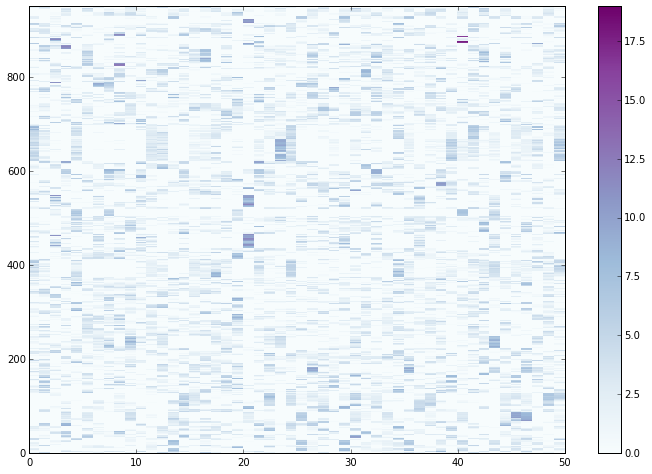

In [6]:
import palettable as pal
cmap=pal.colorbrewer.sequential.BuPu_8.get_mpl_colormap()

get_code = K.function([ae.layers[0].input], [ae.layers[1].output])
code = get_code([x])[0]
df=pd.DataFrame(code)

fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)
h=ax.pcolor(df, cmap=cmap)
ax.margins(0,0)
fig.colorbar(h)

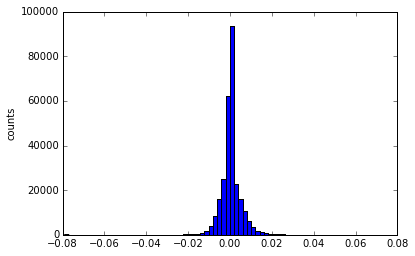

In [8]:
weights = ae.get_weights()[2].flatten()
plt.hist(weights, normed=False, bins=75)
plt.ylabel('counts');

<matplotlib.colorbar.Colorbar instance at 0x11bd82a28>

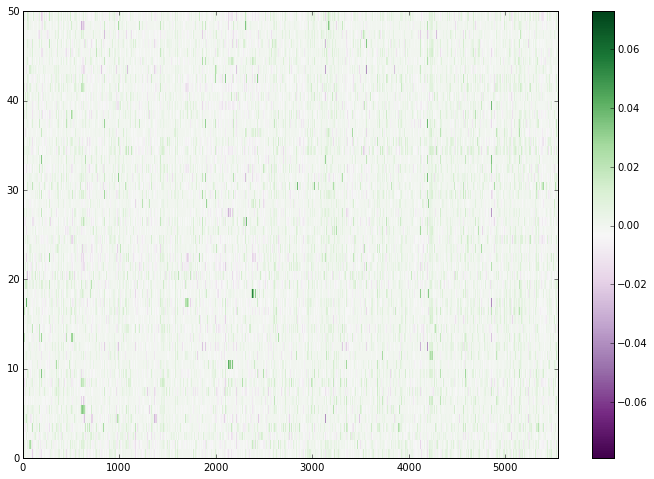

In [9]:
import palettable as pal
cmap=pal.colorbrewer.diverging.PRGn_11.get_mpl_colormap()

df=pd.DataFrame(ae.get_weights()[2])

fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)
h=ax.pcolor(df, cmap=cmap)
ax.margins(0,0)
fig.colorbar(h)

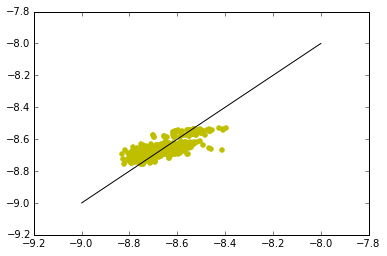

In [16]:
outputs = ae.predict(x)
#pd.DataFrame(code).describe()
i = i-10
plt.scatter(special.logit(y[:,i]), special.logit(outputs[:,i]), color = "y")
plt.plot([-9,-8], [-9,-8],color='k', linestyle='-', linewidth=1)

In [17]:
pd.DataFrame(ae.get_weights()[2]).to_csv("ae_weights.csv")

In [19]:
pd.DataFrame(code).to_csv("ae_codes.csv")

In [237]:
GO = pd.DataFrame.from_csv('GO.txt', sep='\t', header=None)
GO_list = list(GO.ix[:,2])
for i in range(len(GO_list)):
    GO_list[i] = GO_list[i].split(";")

In [255]:
KEGG = pd.DataFrame.from_csv('KEGG.txt', sep='\t', header=None)
KEGG_list = list(KEGG.ix[:,2])
for i in range(len(KEGG_list)):
    KEGG_list[i] = KEGG_list[i].split(";")

In [275]:
w = pd.DataFrame.from_csv("ae_weights.csv")
from scipy import stats
hw = list()
for i in range(w.shape[0]):
    q = stats.mstats.mquantiles(w.iloc[i,:], [.025, .975])
    bool = np.array([not (q[0] < x < q[1]) for x in np.array(w.iloc[i,:])])
    hw.append(raw.columns.values[bool])

In [276]:
w.columns=raw.columns
x = abs(w[KEGG_list[4]]).mean(axis = 1) / abs(w).mean(axis = 1)
np.var(np.log(x))

0.1768486631150636

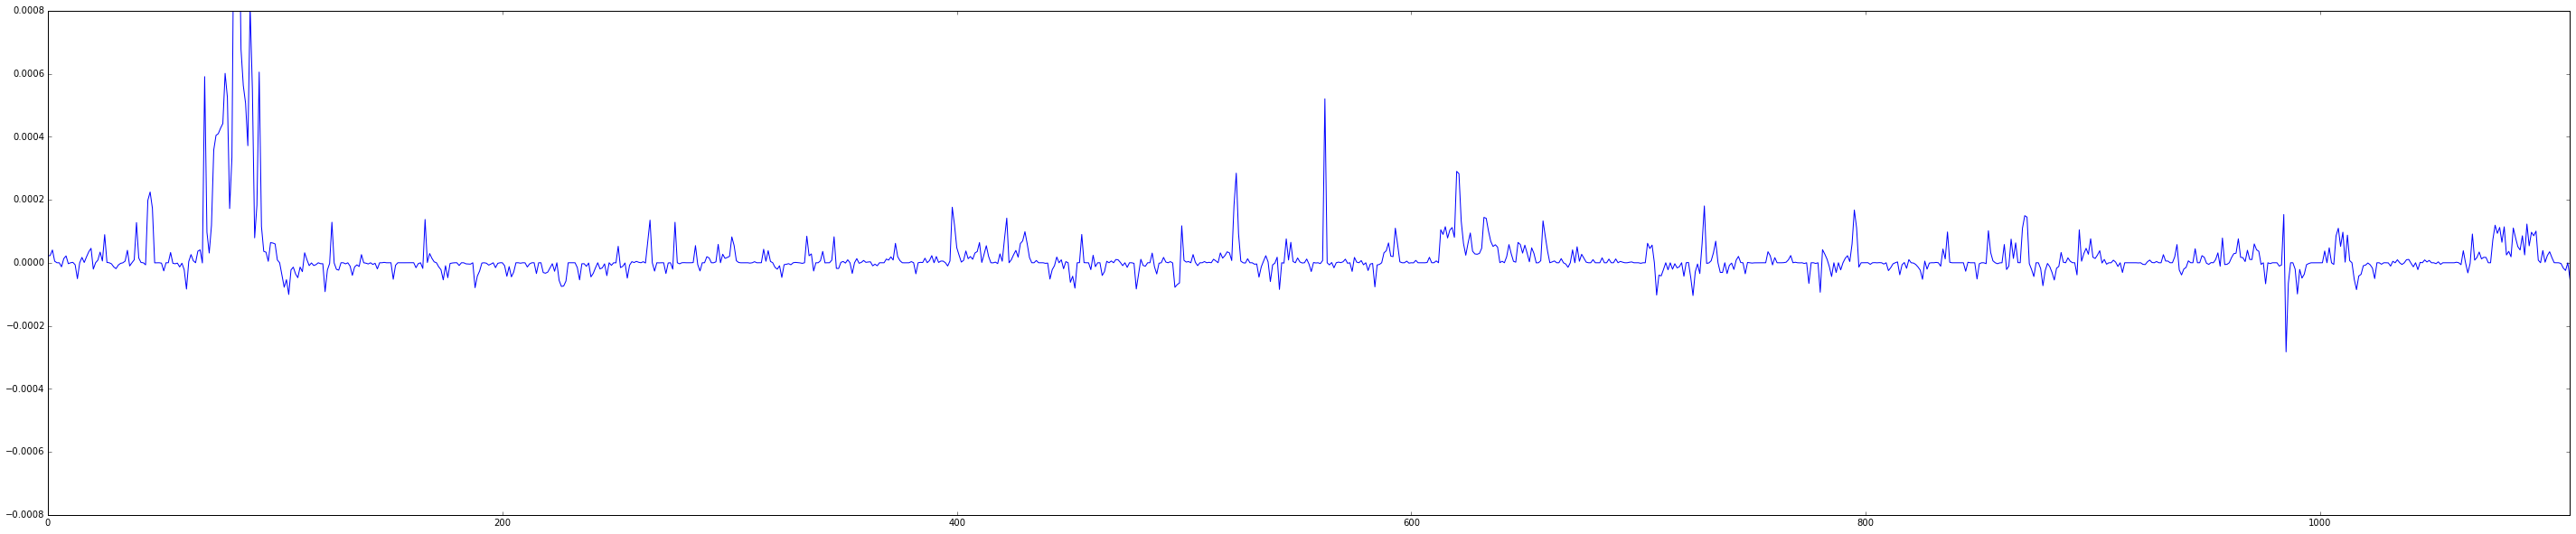

In [442]:
i = 1
from matplotlib.lines import Line2D 
fig, axes = plt.subplots(1)
fig.set_size_inches(50,10)
axes.set_ylim([-.0008,.0008])
axes.set_xlim([0,w.shape[1]/5])
axes.add_line(Line2D(range(w.shape[1]), np.sign(np.array(w)[i,:]) * (np.array(w)[i,:])**2))

In [278]:
ever_hw = set([item for sublist in hw for item in sublist])
ever_KEGG = set([item for sublist in KEGG_list for item in sublist])

print len(ever_KEGG.intersection(ever_hw))
print len(ever_hw) * len(ever_KEGG) / w.shape[1]

1089
1107.48603352


<matplotlib.colorbar.Colorbar instance at 0x166765e60>

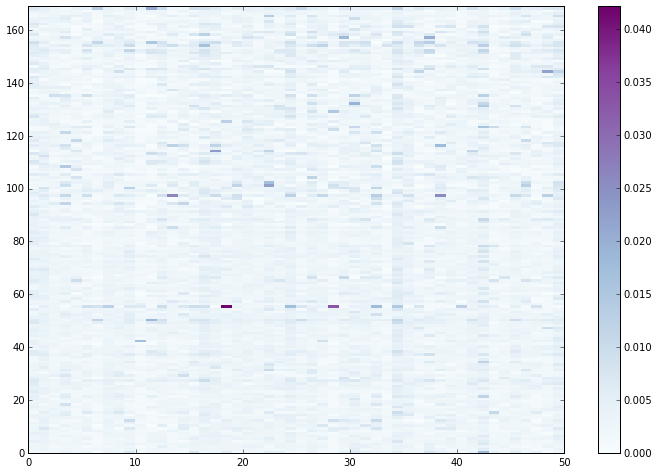

In [430]:
from __future__ import division

kegg_df = pd.DataFrame.from_csv("../data/pseudomonas_kegg_gene_matrix.csv")
names = [str(int(round(float(x[2:])) - 1)) for x in w.columns]
names[0] = "0.1"
kegg_matrix = kegg_df[names].as_matrix()
association = np.dot(kegg_matrix, np.abs(w.transpose()))
for i in range(association.shape[0]):
    association[i,:] = association[i,:] / np.sum(kegg_matrix[i,:])
df=pd.DataFrame(association)


cmap=pal.colorbrewer.sequential.BuPu_8.get_mpl_colormap()

fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)
h=ax.pcolor(df, cmap=cmap)
ax.margins(0,0)
fig.colorbar(h)

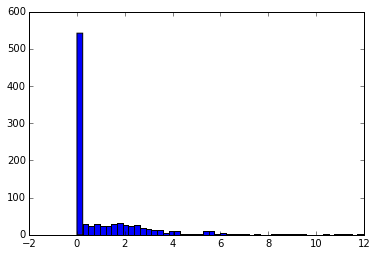

In [446]:
order = association.max(axis = 0).argsort()
KEGG.iloc[abs(association).argmax(axis = 0)[order],0]
plt.hist(np.array(code)[:,3], bins = 50);